This is a notebook for the polymer melt simulations. The folder `Melt` hopefully contain all relavent files for simulations, as well as the final energy `.xvg` files used to calcualte the enthalpy.

# Simulation

The first step of the simulation is to generate a polymer slab. This is done using CHARMM GUI [polymer builder](https://charmm-gui.org/?doc=demo&id=polymer&lesson=1). This will take some time but the out put should allow you to perform annealing simulation on the slab. This would be step3 and step4.

After minimization, annealing, NVT, and NPT simulation we can then solvate our slap. This will be done similarly to the Amino Acid simulation. Using `gmx solvate` command we can create our water and our .`.top` and `.gro` files will automatically update. 

However, we care about wetting enthalpy, which requires all water to end up outside the polymer slab. If there are large gaps in your slab, water may be placed here. Therefore a second approach is to create a second box and solvate this box entirely. By going into the `.gro` files you can increase the box sizes such that both the water box and polymer slab can be put them together using 

`cat polymerslab.gro waterbox.gro > waterslab.gro`

This method then requires you to update the toplogy files, usually is is adjusting the number of atoms at the bottom and ensureing all force fields are corrclty defined. This is straight forward by just copy and pasting the difference in one file to the other. This is step 5 and ultimately is a lot of trial and error until the software cooperates (or it was in my experience). I recommend using VMD to visualise you `.gro` files so you can properly understand what is happening.

One this is done, we can begin actually simulating. First perform a minimization, this is to ensure nothing has broken, then NPT into NVT. Files for these are provided but you can also reusue the ones from the AA sims. The only difference is the NVT sim. This is our production run so make it as long as you would like. Our production sim was $20$ ns. Once simulation is finished, you can extract the potential energy using `gmx energy` command. Simply extract the potential energy and put it aside for later.

Next we move onto the slab simulation. To ensure equal conditions, we first use `gmx make_ndx` to create and index file for our system. In the interactive window use `a OW`, enter and then `q`, lets call this index `waterindex.ndx`. This will make an index group for just TIP3P water, which has atom names `OW`. Using this index we can now create two new `.gro` simulation boxes. One for just the slab and one for just water. 

To create the polymer slab or dryslab box use 

`gmx trjconv -f waterslab.gro -n waterindex.ndx -o dryslab.gro`

In the interactive window choose not whatever the corresponding group to water is.
Repeat for the water simulation, this time choosing only water.

Once you have your boxes you can run your final NVT simulations on them and extract the energies similarly to before.

The next info worth acquiring is the solvent available surface area (SASA) and the density of water in the simulation. The SASA can be acquired using `gmx sasa` command and produces both an `.xvg` file for plottin and `.pdb` file for visualisation in VMD. Density of water can also be acquired very easily but using `gmx density` and passing `waterindex.ndx` for an index. To get a pretty plot for density I would center the tracjectory from the waterslab simulations using 

`gmx trjconv -f traj.xtc -s topol.tpr -o traj_centered.xtc -center -pbc mol`

Then pass `traj_cenetred` in the `gmx density` call. 


In [1]:
import os
wd = os.getcwd()
wd

'/Users/brianmaloney/Desktop/MastersProject/PPsimulation'

In [11]:
import matplotlib.pyplot as plt
import numpy as np
os.chdir("Melt")

time_ws = []
time_ds = []
time_ow = []


energy_waterslab = []
energy_dryslab = []
energy_ow = []


with open("waterslab.xvg") as f:
    for line in f:
        if line.startswith(('@', '#')):
            continue  # Skip comments
        parts = line.split()
        time_ws.append(float(parts[0]))
        energy_waterslab.append(float(parts[1]))

with open("dryslab.xvg") as f:
    for line in f:
        if line.startswith(('@', '#')):
            continue  # Skip comments
        parts = line.split()
        time_ds.append(float(parts[0]))
        energy_dryslab.append(float(parts[1]))
        
with open("wateronly.xvg") as f:
    for line in f:
        if line.startswith(('@', '#')):
            continue  # Skip comments
        parts = line.split()
        time_ow.append(float(parts[0]))
        energy_ow.append(float(parts[1]))
        
# Convert ps → ns
time_ws = np.array(time_ws) / 1000
time_ds = np.array(time_ds) / 1000
time_ow = np.array(time_ow) / 1000



energy_waterslab = np.array(energy_waterslab)/1000000
energy_dryslab = np.array(energy_dryslab)/1000000
energy_ow = np.array(energy_ow)/1000000


# Area 8.0253

# slabs
avg_dry_slab = sum(energy_dryslab) / len(energy_dryslab) * 1000000
avg_water_slab = sum(energy_waterslab) / len(energy_waterslab) * 1000000
avg_ow = sum(energy_ow[10:]) / len(energy_ow[10:]) * 1000000
print("Average Dry Slab Energy: ", avg_dry_slab)
print("Average Water + Slab Energy: ", avg_water_slab)
print("Average Water: ", avg_ow)



enthalpy_dryslab = (avg_water_slab - avg_ow - avg_dry_slab) / (2*(8.0253**2))
print("Enthalpy Dried Slab: ", enthalpy_dryslab)



Average Dry Slab Energy:  -114724.7420074333
Average Water + Slab Energy:  -954017.4304784752
Average Water:  -833419.1326784604
Enthalpy Dried Slab:  -45.59828940205772


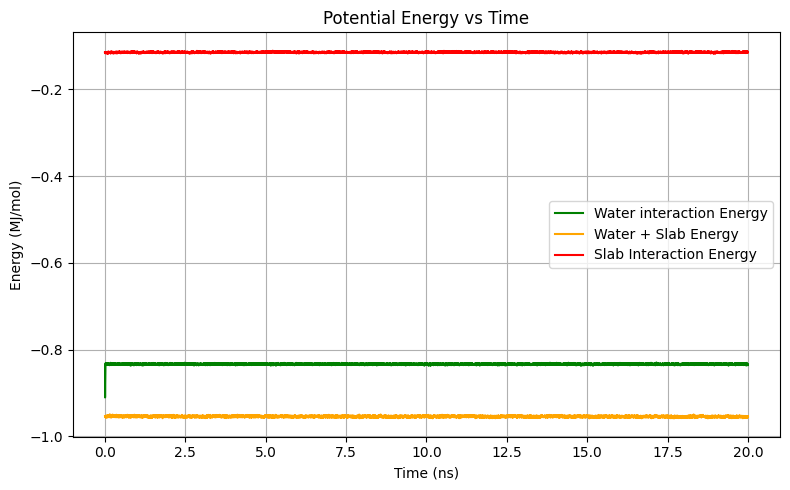

In [5]:
# Total energy plots
plt.figure(figsize=(8,5))
plt.plot(time_ow, energy_ow, color='green', label='Water interaction Energy')
plt.plot(time_ws, energy_waterslab, color='orange', label='Water + Slab Energy')
plt.plot(time_ds, energy_dryslab, color='red', label='Slab Interaction Energy')
plt.xlabel('Time (ns)')
plt.ylabel('Energy (MJ/mol)')
plt.title('Potential Energy vs Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

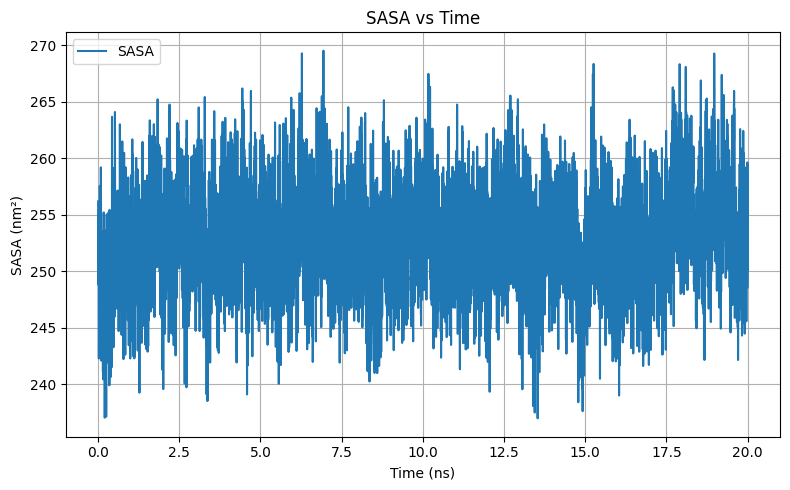

In [6]:
# SASA
time_sasa = []
sasa = []

with open("sasa.xvg") as f:
    for line in f:
        if line.startswith(('@', '#')):
            continue  # Skip comments
        parts = line.split()
        time_sasa.append(float(parts[0]))
        sasa.append(float(parts[1]))

time_sasa = np.array(time_sasa)/1000
plt.figure(figsize=(8,5))
plt.plot(time_sasa, sasa, label='SASA')
plt.xlabel('Time (ns)')
plt.ylabel('SASA (nm²)')
plt.title('SASA vs Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('../graphs/SASA.pdf', format="pdf")
plt.show()

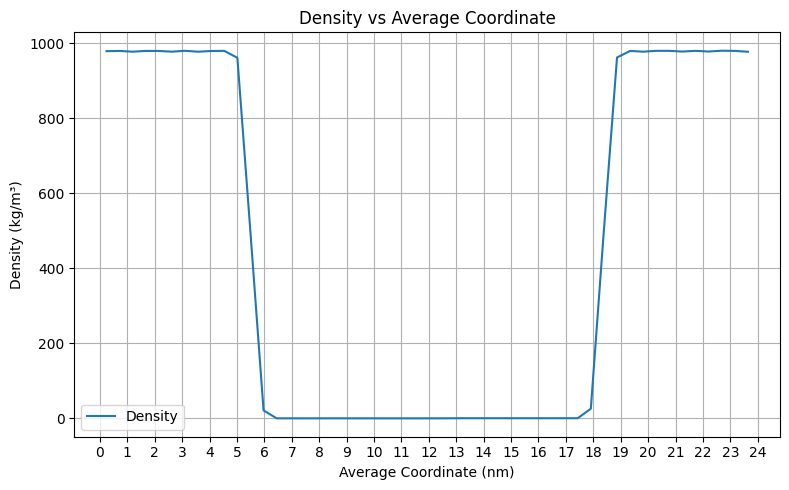

In [7]:
# Density 
time_density = []
density = []

with open("centerdens.xvg") as f:
    for line in f:
        if line.startswith(('@', '#')):
            continue  # Skip comments
        parts = line.split()
        time_density.append(float(parts[0]))
        density.append(float(parts[1]))
        
        
plt.figure(figsize=(8,5))
plt.plot(time_density, density, label='Density')
plt.xlabel('Average Coordinate (nm)')
plt.xticks(np.arange(0, 25, 1))
plt.ylabel('Density (kg/m³)')
plt.title('Density vs Average Coordinate')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('../graphs/density.pdf', format="pdf")
plt.show()